In [1]:
!pip install ipython-autotime
!pip install opensmile
%load_ext autotime
%matplotlib inline

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.4/167.4 kB 5.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 996.2/996.2 kB 33.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.7/68.7 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.2/41.2 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 151.3/151.3 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 39.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.4/138.4 kB 8.4 MB/s eta 0:00:00
  Created wheel for iso-639: filename=iso_639-0.4.5-py3-none-any.whl size=168840 sha256=27b02b6ab7b957bff2cc200b7cbe845f05a266393ba4ddfee6a7d26a906eb091
  Stored in directory: /root/.cache/pip/wheels/d8/78/cc/5478ca3b1c3f602eae6f8cdbd78f909c0a0bfa0bbcb5c7771f
Successfully built iso-639
time: 2.35 ms (started: 2024-08-06 11:5

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import librosa
import opensmile
import os
import gc
import tempfile
import soundfile as sf
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.preprocessing import MinMaxScaler
from scipy.io import wavfile

time: 2.47 s (started: 2024-08-06 11:53:40 +00:00)


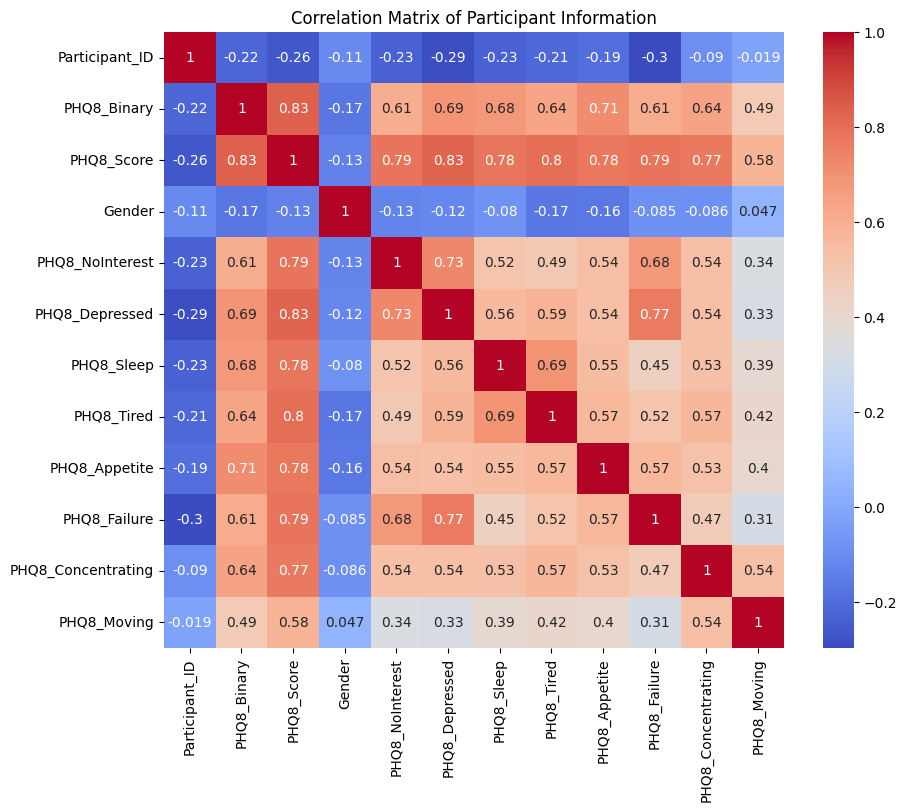

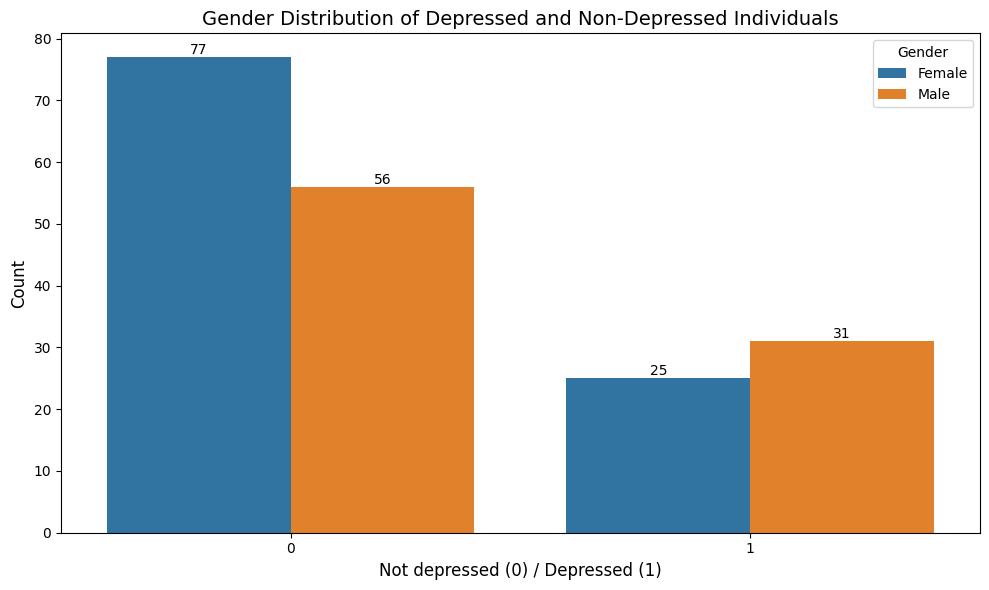

Percentage of depressed Females: 24.5%
Percentage of depressed Males: 35.6%
time: 1.49 s (started: 2024-08-06 11:53:42 +00:00)


In [3]:
BASE_DIR = "/kaggle/input/depression-audio-dataset/depression-speech-all-kaggle/depression-speech-all-kaggle"
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy as np

# Load main CSV file with participant information
participant_info = pd.read_csv("/kaggle/input/depression-audio-dataset/participant-info.csv")
participant_info_fig = pd.read_csv("/kaggle/input/depression-audio-dataset/corr-freq.csv")

# Display correlation matrix
correlation_matrix = participant_info_fig.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title("Correlation Matrix of Participant Information")
plt.show()

# Map gender from 0, 1 to 'Male', 'Female' if necessary
if participant_info['Gender'].dtype == np.int64:
    participant_info['Gender'] = participant_info['Gender'].map({0: 'Male', 1: 'Female'})

# Create the gender distribution plot
plt.figure(figsize=(10, 6))
sns.countplot(data=participant_info, x='PHQ8_Binary', hue='Gender', palette=['#1f77b4', '#ff7f0e'])
plt.title("Gender Distribution of Depressed and Non-Depressed Individuals", fontsize=14)
plt.xlabel("Not depressed (0) / Depressed (1)", fontsize=12)
plt.ylabel("Count", fontsize=12)
for i in plt.gca().containers:
    plt.gca().bar_label(i, label_type='edge')
plt.legend(title="Gender", loc='upper right')
plt.tight_layout()
plt.show()

# Calculate and display percentages
gender_depression = participant_info.groupby(['Gender', 'PHQ8_Binary']).size().unstack()
for gender in gender_depression.index:
    total = gender_depression.loc[gender].sum()
    depressed = gender_depression.loc[gender, 1]
    percentage = (depressed / total) * 100
    print(f"Percentage of depressed {gender}s: {percentage:.1f}%")

In [17]:
def get_participant_paths(participant_id):
    folder = f'{BASE_DIR}/{participant_id}/'
    return f'{folder}{participant_id}_AUDIO.wav', f'{folder}{participant_id}_TRANSCRIPT.csv'

def load_data(participant_id):
    audio_file, transcript_file = get_participant_paths(participant_id)
    y, sr = librosa.load(audio_file)
    transcript = pd.read_csv(transcript_file, sep='\t', header=None,
                             names=['start_time', 'stop_time', 'speaker', 'value'])
    if transcript.iloc[0]['start_time'] == 'start_time':
        transcript = transcript.iloc[1:]
    transcript['start_time'] = transcript['start_time'].astype(float)
    transcript['stop_time'] = transcript['stop_time'].astype(float)
    return y, sr, transcript

def segment_audio(y, sr, transcript):
    participant_segments = transcript[transcript['speaker'] != 'Ellie'].dropna(subset=['start_time', 'stop_time'])
    return np.concatenate([
        y[int(segment['start_time'] * sr):int(segment['stop_time'] * sr)]
        for _, segment in participant_segments.iterrows()
    ])

def extract_opensmile_features(audio, sr):
    smile = opensmile.Smile(
        feature_set=opensmile.FeatureSet.eGeMAPSv02,
        feature_level=opensmile.FeatureLevel.Functionals,
    )
    
    with tempfile.NamedTemporaryFile(suffix=".wav", delete=False) as temp_audio:
        sf.write(temp_audio.name, audio, sr)
        features = smile.process_file(temp_audio.name)
    
    os.unlink(temp_audio.name)
    
    opensmile_features = features.values.flatten()
    
    return opensmile_features, features.columns.tolist()

def process_participant(participant_id):
    y, sr, transcript = load_data(participant_id)
    segmented_audio = segment_audio(y, sr, transcript)
    features, feature_names = extract_opensmile_features(segmented_audio, sr)
    del y, transcript, segmented_audio
    gc.collect()
    return features, feature_names

def augment_audio(audio, sr):
    choice = np.random.choice(['time_stretch', 'pitch_shift'])
    if choice == 'time_stretch':
        rate = np.random.uniform(0.8, 1.2)
        return librosa.effects.time_stretch(audio, rate=rate)
    else:  # pitch_shift
        n_steps = np.random.uniform(-2, 2)
        return librosa.effects.pitch_shift(audio, sr=sr, n_steps=n_steps)

def feature_generator(data_file, augment=False):
    data = pd.read_csv(data_file)
    depression_column = 'PHQ8_Binary' if 'PHQ8_Binary' in data.columns else 'PHQ_Binary'
    for _, row in data.iterrows():
        participant_id = int(row['Participant_ID'])
        print(f"Processing participant_id: {participant_id}")
        y, sr, transcript = load_data(participant_id)
        segmented_audio = segment_audio(y, sr, transcript)
        features, feature_names = extract_opensmile_features(segmented_audio, sr)
        yield features, row[depression_column], feature_names
        
        if augment and row[depression_column] == 1:
            augmented_audio = augment_audio(segmented_audio, sr)
            augmented_features, _ = extract_opensmile_features(augmented_audio, sr)
            yield augmented_features, 1, feature_names
        
        del y, transcript, segmented_audio
        gc.collect()

def process_dataset(data_file, augment=False):
    X = []
    y_binary = []
    feature_names = None
    for features, label_binary, names in feature_generator(data_file, augment):
        X.append(features)
        y_binary.append(label_binary)
        if feature_names is None:
            feature_names = names
        gc.collect()
    return np.array(X), np.array(y_binary), feature_names

time: 7.03 ms (started: 2024-08-06 14:48:54 +00:00)


In [5]:
print("Processing test data...")
X_test, y_test, _ = process_dataset('/kaggle/input/depression-audio-dataset/depression-speech-all-kaggle/depression-speech-all-kaggle/full_test_split.csv', augment=True)
print("Test data processed.")

# Process datasets
print("Processing train data...")
X_train, y_train, feature_names = process_dataset('/kaggle/input/depression-audio-dataset/corr-freq.csv', augment=True)
print("Train data processed.")

Processing test data...
Processing participant_id: 300
Processing participant_id: 301
Processing participant_id: 306
Processing participant_id: 308
Processing participant_id: 309
Processing participant_id: 311
Processing participant_id: 314
Processing participant_id: 323
Processing participant_id: 329
Processing participant_id: 332
Processing participant_id: 334
Processing participant_id: 337
Processing participant_id: 349
Processing participant_id: 354
Processing participant_id: 359
Processing participant_id: 361
Processing participant_id: 365
Processing participant_id: 373
Processing participant_id: 405
Processing participant_id: 407
Processing participant_id: 408
Processing participant_id: 410
Processing participant_id: 411
Processing participant_id: 421
Processing participant_id: 424
Processing participant_id: 431
Processing participant_id: 432
Processing participant_id: 435
Processing participant_id: 438
Processing participant_id: 442
Processing participant_id: 450
Processing part

In [7]:
print(Counter(y_train))
print(Counter(y_test))

Counter({0.0: 100, 1.0: 84})
Counter({0: 33, 1: 28})
time: 1.15 ms (started: 2024-08-06 13:37:56 +00:00)


In [8]:
# Balance the training set
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

time: 164 ms (started: 2024-08-06 13:38:04 +00:00)


In [9]:
print("Train set distribution after balancing:", Counter(y_train_balanced))

Train set distribution after balancing: Counter({0.0: 100, 1.0: 100})
time: 1.03 ms (started: 2024-08-06 13:38:12 +00:00)


In [41]:
scaler = MinMaxScaler()
X_train_balanced_scaled = scaler.fit_transform(X_train_balanced)
X_test_scaled = scaler.transform(X_test)

time: 4.07 ms (started: 2024-08-06 17:36:16 +00:00)


Default Hard Voting Classifier Results:
Accuracy: 0.7049
Precision: 0.7500
Recall: 0.5357
F1 Score: 0.6250
              precision    recall  f1-score   support

           0       0.68      0.85      0.76        33
           1       0.75      0.54      0.63        28

    accuracy                           0.70        61
   macro avg       0.72      0.69      0.69        61
weighted avg       0.71      0.70      0.70        61



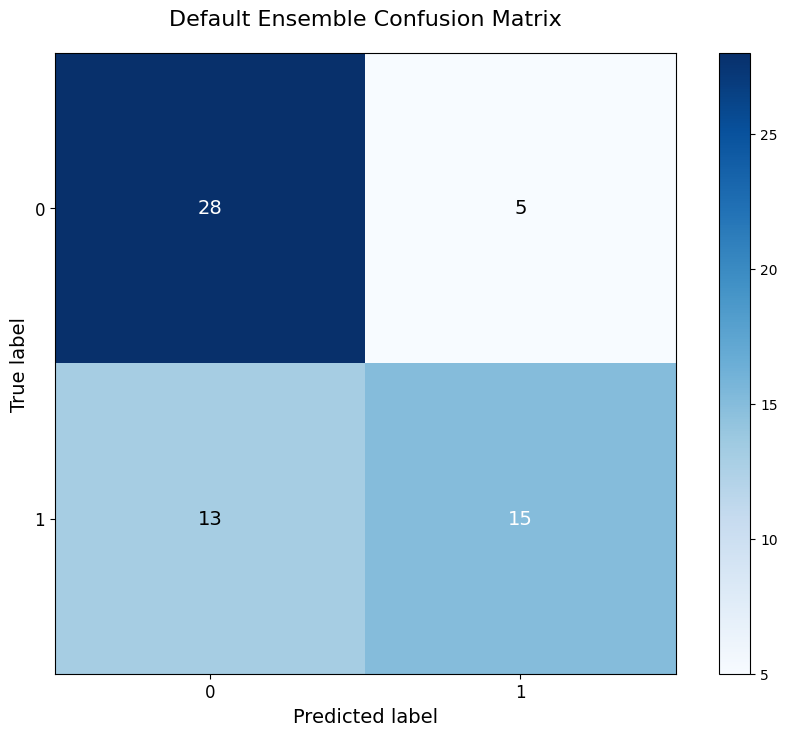

time: 3.31 s (started: 2024-08-06 20:48:40 +00:00)


In [91]:
# Base models with default parameters
decision_tree_default = DecisionTreeClassifier(random_state=42)
random_forest_default = RandomForestClassifier(random_state=42)
gradient_boosting_default = GradientBoostingClassifier(random_state=42)
knn_default = KNeighborsClassifier()

# Fit the base models
decision_tree_default.fit(X_train_balanced_scaled, y_train_balanced)
random_forest_default.fit(X_train_balanced_scaled, y_train_balanced)
gradient_boosting_default.fit(X_train_balanced_scaled, y_train_balanced)
knn_default.fit(X_train_balanced_scaled, y_train_balanced)

# Define the hard voting classifier
voting_clf_default = VotingClassifier(
    estimators=[
        ('decision_tree', decision_tree_default),
        ('random_forest', random_forest_default),
        ('gradient_boosting', gradient_boosting_default),
        ('knn', knn_default)
    ],
    voting='hard'
)

# Fit the Voting Classifier
voting_clf_default.fit(X_train_balanced_scaled, y_train_balanced)

# Predict and evaluate
y_pred_voting_default = voting_clf_default.predict(X_test_scaled)
accuracy_voting_default = accuracy_score(y_test, y_pred_voting_default)
precision_voting_default = precision_score(y_test, y_pred_voting_default)
recall_voting_default = recall_score(y_test, y_pred_voting_default)
f1_voting_default = f1_score(y_test, y_pred_voting_default)

print("Default Hard Voting Classifier Results:")
print(f"Accuracy: {accuracy_voting_default:.4f}")
print(f"Precision: {precision_voting_default:.4f}")
print(f"Recall: {recall_voting_default:.4f}")
print(f"F1 Score: {f1_voting_default:.4f}")
print(classification_report(y_test, y_pred_voting_default))

# Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(title, fontsize=16, pad=20)
    plt.colorbar()
    tick_marks = np.arange(2)
    plt.xticks(tick_marks, ['0', '1'], fontsize=12)
    plt.yticks(tick_marks, ['0', '1'], fontsize=12)
    plt.ylabel('True label', fontsize=14)
    plt.xlabel('Predicted label', fontsize=14)
    
    # Add text annotations
    thresh = cm.max() / 2.
    for i in range(2):
        for j in range(2):
            plt.text(j, i, str(cm[i, j]),
                     ha="center", va="center",
                     color="white" if cm[i, j] > thresh else "black",
                     fontsize=14)
    
    # Adjust layout and save
    plt.tight_layout(pad=3.0)
    plt.savefig(f"{title.replace(' ', '_')}.png", bbox_inches='tight', dpi=300)
    plt.show()
    plt.close()

# Plot and display the confusion matrix
plot_confusion_matrix(y_test, y_pred_voting_default, "Default Ensemble Confusion Matrix")

In [105]:
# Base models with adjusted parameters
decision_tree = DecisionTreeClassifier(min_samples_leaf=4, min_samples_split=12, random_state=42)
random_forest = RandomForestClassifier(min_samples_split=12, n_estimators=200, random_state=42, class_weight='balanced')
gradient_boosting = GradientBoostingClassifier(learning_rate=0.01, max_depth=6, min_samples_leaf=2,
                                               min_samples_split=10, random_state=42, subsample=0.9)
knn = KNeighborsClassifier(n_neighbors=5)

# Fit the base models
decision_tree.fit(X_train_balanced_scaled, y_train_balanced)
random_forest.fit(X_train_balanced_scaled, y_train_balanced)
gradient_boosting.fit(X_train_balanced_scaled, y_train_balanced)
knn.fit(X_train_balanced_scaled, y_train_balanced)

# Define the hard voting classifier
voting_clf = VotingClassifier(
    estimators=[
        ('decision_tree', decision_tree),
        ('random_forest', random_forest),
        ('gradient_boosting', gradient_boosting),
        ('knn', knn)
    ],
    voting='hard'
)

# Fit the Voting Classifier
voting_clf.fit(X_train_balanced_scaled, y_train_balanced)

# Predict and evaluate
y_pred_voting = voting_clf.predict(X_test_scaled)
accuracy_voting = accuracy_score(y_test, y_pred_voting)
precision_voting = precision_score(y_test, y_pred_voting)
recall_voting = recall_score(y_test, y_pred_voting)
f1_voting = f1_score(y_test, y_pred_voting)

print("Step 1: Initial Hard Voting Classifier Results:")
print(f"Accuracy: {accuracy_voting:.4f}")
print(f"Precision: {precision_voting:.4f}")
print(f"Recall: {recall_voting:.4f}")
print(f"F1 Score: {f1_voting:.4f}")
print(classification_report(y_test, y_pred_voting))



# Adjust Random Forest to favor recall
random_forest_adjusted = RandomForestClassifier(min_samples_split=10, n_estimators=300, random_state=42, 
                                                class_weight='balanced_subsample', max_features='sqrt')
random_forest_adjusted.fit(X_train_balanced_scaled, y_train_balanced)

voting_clf_adjusted = VotingClassifier(
    estimators=[
        ('decision_tree', decision_tree),
        ('random_forest', random_forest_adjusted),
        ('gradient_boosting', gradient_boosting),
        ('knn', knn)
    ],
    voting='hard'
)

voting_clf_adjusted.fit(X_train_balanced_scaled, y_train_balanced)
y_pred_voting_adjusted = voting_clf_adjusted.predict(X_test_scaled)

accuracy_voting_adjusted = accuracy_score(y_test, y_pred_voting_adjusted)
precision_voting_adjusted = precision_score(y_test, y_pred_voting_adjusted)
recall_voting_adjusted = recall_score(y_test, y_pred_voting_adjusted)
f1_voting_adjusted = f1_score(y_test, y_pred_voting_adjusted)

print("\nStep 2: Adjusted Random Forest Results:")
print(f"Accuracy: {accuracy_voting_adjusted:.4f}")
print(f"Precision: {precision_voting_adjusted:.4f}")
print(f"Recall: {recall_voting_adjusted:.4f}")
print(f"F1 Score: {f1_voting_adjusted:.4f}")
print(classification_report(y_test, y_pred_voting_adjusted))

# Adjust Gradient Boosting to favor recall
gradient_boosting_adjusted = GradientBoostingClassifier(learning_rate=0.05, max_depth=5, min_samples_leaf=1,
                                                        min_samples_split=8, n_estimators=250, subsample=0.8, random_state=42)
gradient_boosting_adjusted.fit(X_train_balanced_scaled, y_train_balanced)

voting_clf_final = VotingClassifier(
    estimators=[
        ('decision_tree', decision_tree),
        ('random_forest', random_forest_adjusted),
        ('gradient_boosting', gradient_boosting_adjusted),
        ('knn', knn)
    ],
    voting='hard',
    weights=[1, 3, 2, 1]  # Give more weight to Random Forest and Gradient Boosting
)

voting_clf_final.fit(X_train_balanced_scaled, y_train_balanced)
y_pred_voting_final = voting_clf_final.predict(X_test_scaled)

accuracy_voting_final = accuracy_score(y_test, y_pred_voting_final)
precision_voting_final = precision_score(y_test, y_pred_voting_final)
recall_voting_final = recall_score(y_test, y_pred_voting_final)
f1_voting_final = f1_score(y_test, y_pred_voting_final)

print("\nStep 3: Final Adjusted Hard Voting Classifier Results:")
print(f"Accuracy: {accuracy_voting_final:.4f}")
print(f"Precision: {precision_voting_final:.4f}")
print(f"Recall: {recall_voting_final:.4f}")
print(f"F1 Score: {f1_voting_final:.4f}")
print(classification_report(y_test, y_pred_voting_final))


# Function to evaluate and plot individual classifier performance
def evaluate_classifier(classifier, X_train, y_train, X_test, y_test, name):
    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    print(f"\n{name} Results:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(classification_report(y_test, y_pred))


# Evaluate individual classifiers
evaluate_classifier(decision_tree, X_train_balanced_scaled, y_train_balanced, X_test_scaled, y_test, "Decision Tree")
evaluate_classifier(random_forest_adjusted, X_train_balanced_scaled, y_train_balanced, X_test_scaled, y_test, "Random Forest")
evaluate_classifier(gradient_boosting_adjusted, X_train_balanced_scaled, y_train_balanced, X_test_scaled, y_test, "Gradient Boosting")
evaluate_classifier(knn, X_train_balanced_scaled, y_train_balanced, X_test_scaled, y_test, "KNN")

# Evaluate final ensemble
voting_clf_final.fit(X_train_balanced_scaled, y_train_balanced)
y_pred_final = voting_clf_final.predict(X_test_scaled)
accuracy_final = accuracy_score(y_test, y_pred_final)
precision_final = precision_score(y_test, y_pred_final)
recall_final = recall_score(y_test, y_pred_final)
f1_final = f1_score(y_test, y_pred_final)

print("\nFinal Ensemble Results:")
print(f"Accuracy: {accuracy_final:.4f}")
print(f"Precision: {precision_final:.4f}")
print(f"Recall: {recall_final:.4f}")
print(f"F1 Score: {f1_final:.4f}")
print(classification_report(y_test, y_pred_final))



Step 1: Initial Hard Voting Classifier Results:
Accuracy: 0.8033
Precision: 0.9000
Recall: 0.6429
F1 Score: 0.7500
              precision    recall  f1-score   support

           0       0.76      0.94      0.84        33
           1       0.90      0.64      0.75        28

    accuracy                           0.80        61
   macro avg       0.83      0.79      0.79        61
weighted avg       0.82      0.80      0.80        61


Step 2: Adjusted Random Forest Results:
Accuracy: 0.8033
Precision: 0.9000
Recall: 0.6429
F1 Score: 0.7500
              precision    recall  f1-score   support

           0       0.76      0.94      0.84        33
           1       0.90      0.64      0.75        28

    accuracy                           0.80        61
   macro avg       0.83      0.79      0.79        61
weighted avg       0.82      0.80      0.80        61


Step 3: Final Adjusted Hard Voting Classifier Results:
Accuracy: 0.7869
Precision: 0.7778
Recall: 0.7500
F1 Score: 0.7636


In [106]:


def get_top_features(classifier, feature_names, n=10):
    if hasattr(classifier, 'feature_importances_'):
        importances = classifier.feature_importances_
    elif hasattr(classifier, 'coef_'):
        importances = np.abs(classifier.coef_[0])
    else:
        return None  # For KNN, which doesn't have feature importances
    
    top_indices = importances.argsort()[-n:][::-1]
    top_features = [(feature_names[i], importances[i]) for i in top_indices]
    return top_features

# Get top features for each classifier in the final voting classifier
top_features_dt = get_top_features(voting_clf_final.named_estimators_['decision_tree'], feature_names)
top_features_rf = get_top_features(voting_clf_final.named_estimators_['random_forest'], feature_names)
top_features_gb = get_top_features(voting_clf_final.named_estimators_['gradient_boosting'], feature_names)

# Print top features for each classifier
classifiers = [
    ("Decision Tree", top_features_dt),
    ("Random Forest", top_features_rf),
    ("Gradient Boosting", top_features_gb)
]

for name, top_features in classifiers:
    if top_features:
        print(f"\nTop 10 features for {name}:")
        for feature, importance in top_features:
            print(f"{feature}: {importance:.4f}")

# Find common features
common_features = set([f for f, _ in top_features_dt]) & \
                  set([f for f, _ in top_features_rf]) & \
                  set([f for f, _ in top_features_gb])

print("\nCommon features across all classifiers:")
for feature in common_features:
    print(feature)


Top 10 features for Decision Tree:
shimmerLocaldB_sma3nz_stddevNorm: 0.3747
spectralFlux_sma3_stddevNorm: 0.0870
jitterLocal_sma3nz_amean: 0.0698
F0semitoneFrom27.5Hz_sma3nz_meanFallingSlope: 0.0682
F3frequency_sma3nz_stddevNorm: 0.0651
alphaRatioV_sma3nz_stddevNorm: 0.0609
logRelF0-H1-H2_sma3nz_stddevNorm: 0.0565
F1bandwidth_sma3nz_stddevNorm: 0.0493
F0semitoneFrom27.5Hz_sma3nz_stddevNorm: 0.0460
alphaRatioUV_sma3nz_amean: 0.0389

Top 10 features for Random Forest:
shimmerLocaldB_sma3nz_stddevNorm: 0.0710
loudness_sma3_meanRisingSlope: 0.0378
loudness_sma3_stddevRisingSlope: 0.0358
loudnessPeaksPerSec: 0.0309
F2frequency_sma3nz_stddevNorm: 0.0270
loudness_sma3_stddevFallingSlope: 0.0258
slopeV0-500_sma3nz_amean: 0.0256
VoicedSegmentsPerSec: 0.0206
loudness_sma3_meanFallingSlope: 0.0178
spectralFlux_sma3_stddevNorm: 0.0163

Top 10 features for Gradient Boosting:
shimmerLocaldB_sma3nz_stddevNorm: 0.2008
loudness_sma3_meanRisingSlope: 0.0452
F2frequency_sma3nz_stddevNorm: 0.0438
slopeV0